# Twitter Multi-Network Crawl/Query => Graph

## i. Load & Initialize

In [1]:
#!pip install python-decouple
#!pip install trio
import json
import tweepy
import re
from collections import Counter
import time
from decouple import config
import trio
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

## ii. Load Twitter Credentials

In [2]:
# if running in colab, upload `.env` as `env` then run:
#!mv env .env

#Load Twitter Credentials File
TWITTER_AUTH = tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
TWITTER_AUTH.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))
TWITTER = tweepy.API(TWITTER_AUTH)

## 1. Capture current TwiterAPI rate limit status

In [3]:
# Check the limit before running the function, then check again after and compare. 
start_api_check = TWITTER.rate_limit_status()
limits_alpha = json_normalize(start_api_check)

## 2.  Function: Retrieve User Interactions

In [4]:
async def async_get_user_interactions(search, output, next_query, limit):
    """Crawls the targeted user's timeline and returns interactions.
    Args:
        `search`, string: The name of the user who's timeline to search.
        `output`, list of tuples: paired list of search & interaction targets. 
        `next_query`, list: a list of names to search on the next run. 
        `limit`, int: A flag to indicate how many results should be returned. 
    
    Functionality:
        Initialize search for the specific user.
        Get the user's tweets from their timeline. 
        Cycle through all the tweets' text and join it into a mega-string.
        Do some standardizing and replacing.
        Strip away everything except usernames, into a string. 
        Make a list of the counts, and take the top (X) most common people. 
        Creates a list of the `top` people. No duplicates 
        Tuple the results of the search & output together.
        Make search inputs for the next level of crawling.
    
    Returns:
        This function is async and has no return statement, rather it 
        instead updates the values of `output` and `next_query` extending
        the lists that were passed to it as args.
    """
    twitter_user = TWITTER.get_user(search)
    tweets = twitter_user.timeline(
                count=200,
                exclude_replies=False,
                include_rts=True,
                tweet_mode='extended'
    )
    b = [ i.full_text for i in tweets ]
    b = " ".join(b)
    b = b.lower()
    b = b.replace(search, "")
    out = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
    top = Counter(out).most_common(limit)
    
    if limit > 0:
        interactions = []
        for interaction_count in top:
            interactions += ([interaction_count[0]] * interaction_count[1])

        tweet_data = [(search, i) for i in interactions]
        output.extend(tweet_data)

        next_target_users = [person[0] for person in top]
        next_query.extend(next_target_users)
    
    elif limit == -1: 
        
        # Tuple the results of the search & output together.
        tweet_data = [(search, i) for i in out]
        output = output.extend(tweet_data)
    

## 2. Async multi-query using Trio to retrieve data

In [5]:
async def interaction_chain():
    """Calls our async function & loops through it for each target user."""
    # input settings
    first_users = ['austen','bwinterrose','justinkhan','tommycollison']
    first_limit = 10 # -1 is no limit, anything above 1 sets limit.
    second_limit = 10 # -1 is no limit, anything above 1 sets limit. 
    
    # function variables
    data = []
    next_users = []
    start_time = time.time()
    
    print("----------Entering 1st level. Searching the following users:----------")
    print(first_users)
    
    # Level 1 Run. 
    loop_num = 1
    async with trio.open_nursery() as nursery:
        for user in first_users:
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            nursery.start_soon(async_get_user_interactions, user, data, next_users, first_limit)
    
    print("----------Level 1 completed. Time so far:", time.time() - start_time)
    
    # Remove Level 1 output duplicates
    def dedupe(x):
        return list(dict.fromkeys(x))
    
    next_users = dedupe(next_users)
    print("Level 1 Connections found:", len(next_users))
    print("---------Now Searching the following users")
    display(next_users)
    
    # Level 2 Run.
    loop_num = 1
    async with trio.open_nursery() as nursery:
        for user in next_users:
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            nursery.start_soon(async_get_user_interactions, user, data, next_users, second_limit)
    
    print("Total time:", time.time() - start_time)
    print("Connections found:", len(data))
    return data

## 3. Call the async `Trio` function. 

In [6]:
data = trio.run(interaction_chain)

----------Entering 1st level. Searching the following users:----------
['austen', 'bwinterrose', 'justinkhan', 'tommycollison']
Loop #  1  . Time so far: 0.00022411346435546875
Loop #  2  . Time so far: 0.00036406517028808594
Loop #  3  . Time so far: 0.0006358623504638672
Loop #  4  . Time so far: 0.001293182373046875
----------Level 1 completed. Time so far: 4.033836126327515
Level 1 Connections found: 27
---------Now Searching the following users


['lambdaschool',
 'honestduane',
 'rjnance',
 'johnnewcastle2',
 'slouischarles',
 'bitcoinbingbong',
 'ryanallred',
 'webdevmason',
 'ohmaar1',
 'danoherrin',
 'austen',
 'calebhicks',
 'trevmckendrick',
 'mitchellbwright',
 'ouraring',
 'ryanleehamblin',
 'mckaywrigley',
 'davecraige',
 'sunjieming',
 'kaggle',
 'superhuman',
 'tommycollison',
 'paulg',
 'mwseibel',
 'arachnocapital2',
 'rasbt',
 'jason']

Loop #  1  . Time so far: 4.045414924621582
Loop #  2  . Time so far: 4.048840045928955
Loop #  3  . Time so far: 4.048962116241455
Loop #  4  . Time so far: 4.049975156784058
Loop #  5  . Time so far: 4.050724983215332
Loop #  6  . Time so far: 4.051645040512085
Loop #  7  . Time so far: 4.052659034729004
Loop #  8  . Time so far: 4.052827835083008
Loop #  9  . Time so far: 4.057668924331665
Loop #  10  . Time so far: 4.057749032974243
Loop #  11  . Time so far: 4.057823896408081
Loop #  12  . Time so far: 4.057870864868164
Loop #  13  . Time so far: 4.058010816574097
Loop #  14  . Time so far: 4.058117866516113
Loop #  15  . Time so far: 4.0588438510894775
Loop #  16  . Time so far: 4.058967113494873
Loop #  17  . Time so far: 4.059454917907715
Loop #  18  . Time so far: 4.059548854827881
Loop #  19  . Time so far: 4.059619903564453
Loop #  20  . Time so far: 4.059727907180786
Loop #  21  . Time so far: 4.060060977935791
Loop #  22  . Time so far: 4.060200929641724
Loop #  23  . Time

## 4. Prep the data for conversion into a `networkx MultiDiGraph` object

In [7]:
# DF before Groupby
df = pd.DataFrame(data, columns=['source_user', 'interaction_user'])
display(df.shape)
display(df.head(5))

# Create groupby counts
df_group = df.groupby(['source_user','interaction_user']).size().reset_index().rename(columns={0: "count"})
display(df_group.head())
display(df_group.shape)

# Create "Normalized" interaction weights for each user's interactions. 
a = df_group.groupby('source_user')['count'].transform('sum')
df_group['weight'] = df_group['count'].div(a)
display(df_group.head())
display(df_group.shape)

(2619, 2)

,source_user,interaction_user
0,austen,lambdaschool
1,austen,lambdaschool
2,austen,lambdaschool
3,austen,lambdaschool
4,austen,lambdaschool


,source_user,interaction_user,count
0,arachnocapital2,argumatronic,6
1,arachnocapital2,arrdem,4
2,arachnocapital2,austen,4
3,arachnocapital2,chiefscientist,4
4,arachnocapital2,chris__martin,8


(280, 3)

,source_user,interaction_user,count,weight
0,arachnocapital2,argumatronic,6,0.076923
1,arachnocapital2,arrdem,4,0.051282
2,arachnocapital2,austen,4,0.051282
3,arachnocapital2,chiefscientist,4,0.051282
4,arachnocapital2,chris__martin,8,0.102564


(280, 4)

## 5. Convert the Pandas Dataframe to Networkx Graph

In [8]:
%%time
# Create the graph object 
DG = nx.from_pandas_edgelist(df_group, "source_user", "interaction_user",
                            edge_attr=['weight', "count"], 
                             create_using=nx.MultiGraph())

# Check how many nodes are on the graph now. 
bicomponents = list(nx.biconnected_components(DG))
len(bicomponents)

CPU times: user 7.21 ms, sys: 1.92 ms, total: 9.13 ms
Wall time: 10.3 ms


In [9]:
bicomponents = list(nx.biconnected_components(DG))
len(bicomponents)

186

## 6. Graph the Networkx graph objects. 

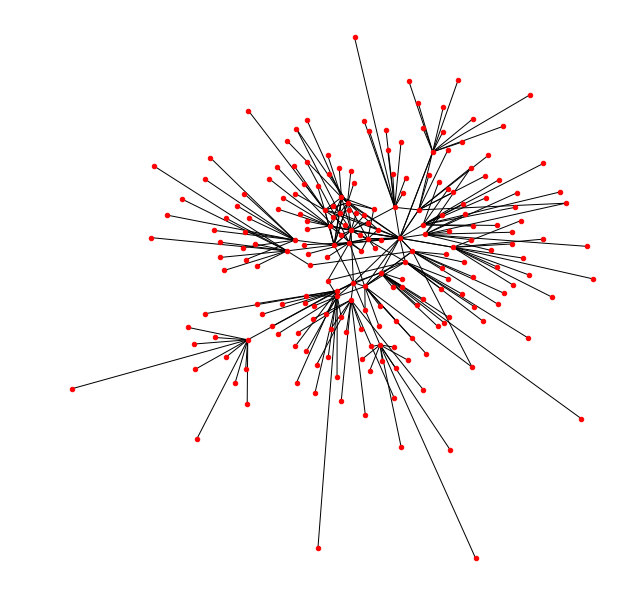

CPU times: user 3.1 s, sys: 383 ms, total: 3.48 s
Wall time: 4.4 s


In [10]:
%%time
fig = plt.figure(figsize=(8,8))
nx.draw_kamada_kawai(DG,node_size=20)
plt.show()

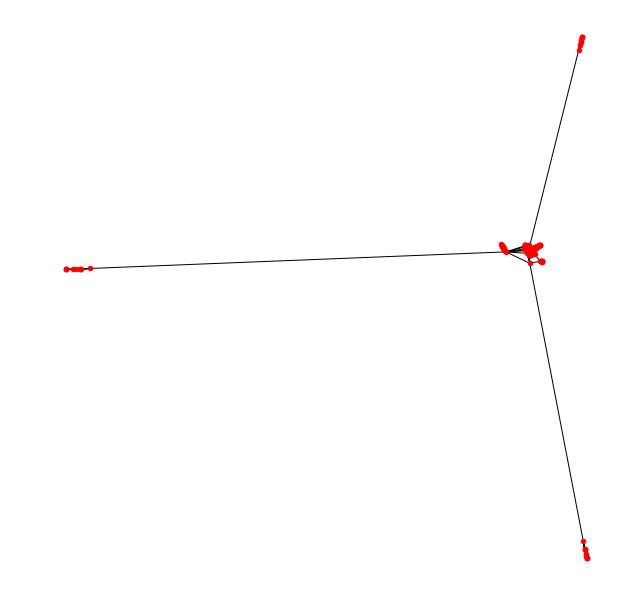

CPU times: user 444 ms, sys: 95.4 ms, total: 539 ms
Wall time: 651 ms


In [11]:
%%time
fig = plt.figure(figsize=(8,8))
nx.draw_spectral(DG, node_size=20)
plt.show()

## 7. Query TwitterAPI and Inspect Rate Usage

In [12]:
# Query API 
end_api_check = TWITTER.rate_limit_status()
limits_beta = json_normalize(end_api_check).T
limits_beta.rename(columns = {0:'beta',}, inplace = True)

# Compare the change of ALL API ENDPOINTS between limits, alpha (before run), and beta (after run.)
limits_delta = limits_alpha.T.copy()
limits_delta['beta'] = limits_beta['beta']
limits_delta = limits_delta.reset_index(drop=False)
limits_delta.rename(columns = {0:'alpha', 'index':'api_endpoint'}, inplace = True)
limits_delta = limits_delta[['api_endpoint','alpha', 'beta']].assign(delta=limits_delta.alpha != limits_delta.beta)
limits_delta['type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 1, expand = True)[0]
limits_delta['sub_type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[1]
limits_delta['api_path'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[2].str.rsplit(pat = '.', n = 1, expand = True)[0]
limits_delta['method'] = limits_delta.api_path.str.rsplit(pat = '/', n = 1, expand = True)[1]
limits_delta['stat'] = limits_delta.api_endpoint.str.rsplit(pat = '.', n = 1, expand = True)[1]
limits_delta = limits_delta[['type', 'sub_type', 'api_path', 'method', 'stat', 'alpha', 'beta', 'delta']]

# Display filtered df. 
limits_delta[(limits_delta['stat'].str.contains("reset") == False) & (limits_delta['delta']==True)]


,type,sub_type,api_path,method,stat,alpha,beta,delta
50,resources,application,/application/rate_limit_status,rate_limit_status,remaining,179,178,True
365,resources,statuses,/statuses/user_timeline,user_timeline,remaining,807,900,True
431,resources,users,/users/show/:id,:id,remaining,807,900,True
